# Completion profiling

Profiling avec [cProfile](https://docs.python.org/3.7/library/profile.html), [memory_profiler](https://pypi.org/project/memory-profiler/), [pyinstrument](https://github.com/joerick/pyinstrument), [snakeviz](https://jiffyclub.github.io/snakeviz/).

[line_profiler](https://github.com/rkern/line_profiler) ne semble pas plus être maintenu.

In [1]:
%matplotlib inline

## Setup

### Function to profile

In [2]:
from mlstatpy.nlp.completion import CompletionTrieNode


def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(weights) * 1.0
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0]) for p, w in per]
    wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keystroke2(w)[0]) for p, w in per]
    gain = sum(g * p / total for w, p, g in wks)
    gain_dyn = sum(g * p / total for w, p, g in wks_dyn)
    gain_dyn2 = sum(g * p / total for w, p, g in wks_dyn2)
    ave_length = sum(len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

### Data

In [3]:
from mlstatpy.data.wikipedia import download_titles

file_titles = download_titles(country="fr")

In [4]:
len(file_titles)

33

In [5]:
from mlstatpy.data.wikipedia import enumerate_titles

list_titles = list(
    sorted(set(_ for _ in enumerate_titles(file_titles) if "A" <= _[0] <= "Z"))
)

In [6]:
import random

sample1000 = random.sample(list_titles, 1000)
with open("sample1000.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(sample1000))

## Standard modules

### cProfile

In [7]:
import cProfile, io, pstats, os


def toprofile0(lines):
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))


def doprofile(lines, filename):
    pr = cProfile.Profile()
    pr.enable()
    toprofile0(lines)
    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats("cumulative")
    ps.print_stats()
    rem = os.path.normpath(os.path.join(os.getcwd(), "..", "..", ".."))
    res = s.getvalue().replace(rem, "")
    ps.dump_stats(filename)
    return res

In [8]:
r = doprofile(sample1000, "completion.prof")
print(r)

         1311797 function calls in 1.865 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.865    1.865 <ipython-input-7-d2b6d910fdd7>:3(toprofile0)
        1    0.000    0.000    1.865    1.865 <ipython-input-2-684f3e860cf5>:3(gain_dynamique_moyen_par_mot)
        1    0.241    0.241    1.232    1.232 \src\mlstatpy\nlp\completion.py:415(precompute_stat)
    15982    0.244    0.000    0.770    0.000 \src\mlstatpy\nlp\completion.py:503(merge_completions)
        1    0.088    0.088    0.366    0.366 \src\mlstatpy\nlp\completion.py:450(update_stat_dynamic)
    15982    0.307    0.000    0.314    0.000 {built-in method builtins.__build_class__}
        1    0.194    0.194    0.220    0.220 \src\mlstatpy\nlp\completion.py:203(build)
    16982    0.094    0.000    0.165    0.000 \src\mlstatpy\nlp\completion.py:555(update_dynamic_minimum_keystroke)
    36051    0.114    0.000    0.130    0.000 \sr

## Others informations when profiling

### memory_profiler

See [memory_profiler](https://pypi.python.org/pypi/memory_profiler/0.41). Version 0.56 is bugged (see [#258](https://github.com/pythonprofilers/memory_profiler/issues/258)).

In [9]:
from memory_profiler import profile

%load_ext memory_profiler

In [10]:
%memit toprofile0(sample1000)

peak memory: 411.20 MiB, increment: 18.40 MiB


In [11]:
from io import StringIO

st = StringIO()


@profile(stream=st)
def toprofile(lines):
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))


toprofile(sample1000)

ERROR: Could not find file <ipython-input-11-7512ff5cdee3>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.


In [12]:
%%file temp_mem_profile.py

from mlstatpy.nlp.completion import CompletionTrieNode
from memory_profiler import profile


@profile(precision=4)
def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(weights) * 1.0
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0]) for p, w in per]
    wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keystroke2(w)[0]) for p, w in per]
    gain = sum(g * p / total for w, p, g in wks)
    gain_dyn = sum(g * p / total for w, p, g in wks_dyn)
    gain_dyn2 = sum(g * p / total for w, p, g in wks_dyn2)
    ave_length = sum(len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length


@profile(precision=4)
def toprofile():
    with open("sample1000.txt", "r", encoding="utf-8") as f:
        lines = [_.strip("\n\r ") for _ in f.readlines()]
    gain_dynamique_moyen_par_mot(lines, [1.0] * len(lines))


toprofile()

Overwriting temp_mem_profile.py


In [13]:
import sys

cmd = sys.executable
from sphinx_runpython.runpython import run_cmd

cmd += " -m memory_profiler temp_mem_profile.py"
out, err = run_cmd(cmd, wait=True)
print(out)

Filename: temp_mem_profile.py

Line #    Mem usage    Increment   Line Contents
     5  56.7930 MiB  56.7930 MiB   @profile(precision=4)
     6                             def gain_dynamique_moyen_par_mot(queries, weights):
     7  56.7930 MiB   0.0000 MiB       per = list(zip(weights, queries))
     8  56.7930 MiB   0.0000 MiB       total = sum(weights) * 1.0
     9  56.7930 MiB   0.0000 MiB       res = []
    10  63.3047 MiB   6.4492 MiB       trie = CompletionTrieNode.build([(None, q) for _, q in per])
    11  71.0742 MiB   7.7695 MiB       trie.precompute_stat()
    12  80.6211 MiB   9.5469 MiB       trie.update_stat_dynamic()
    13  80.7305 MiB   0.1094 MiB       wks = [(w, p, len(w) - trie.min_keystroke0(w)[0]) for p, w in per]
    14  80.7930 MiB   0.0469 MiB       wks_dyn = [(w, p, len(w) - trie.min_dynamic_keystroke(w)[0])
    15  80.7930 MiB   0.0000 MiB                  for p, w in per]
    16  80.8398 MiB   0.0430 MiB       wks_dyn2 = [(w, p, len(w) - trie.min_dynamic_keys

## Static Visualization

### pyinstrument

See [pyinstrument](https://github.com/joerick/pyinstrument).

In [14]:
from pyinstrument import Profiler

profiler = Profiler(use_signal=False)
profiler.start()

toprofile0(sample1000)

profiler.stop()
out = profiler.output_text(unicode=False, color=False)
print(out.replace("\\", "/"))


  _     ._   __/__   _ _  _  _ _/_   Recorded: 18:17:34  Samples:  1048
 /_//_/// /_/ / //_// / //_'/ //     Duration: 1.802     CPU time: 1.703
/   _/                      v3.0.1

Program:  -f pstats completion.prof -o completion.dot

1.799 run_code  IPython/core/interactiveshell.py:3288
`- 1.799 <module>  <ipython-input-18-f16978ea99ef>:6
   `- 1.799 toprofile0  <ipython-input-7-d2b6d910fdd7>:3
      `- 1.799 gain_dynamique_moyen_par_mot  <ipython-input-2-684f3e860cf5>:3
         |- 1.251 precompute_stat  mlstatpy/nlp/completion.py:415
         |  |- 0.917 merge_completions  mlstatpy/nlp/completion.py:503
         |  |  |- 0.771 [self]  
         |  |  `- 0.136 <listcomp>  mlstatpy/nlp/completion.py:523
         |  |- 0.224 [self]  
         |  |- 0.051 update_minimum_keystroke  mlstatpy/nlp/completion.py:542
         |  |- 0.037 <genexpr>  mlstatpy/nlp/completion.py:435
         |  `- 0.021 leaves  mlstatpy/nlp/completion.py:132
         |- 0.289 update_stat_dynamic  mlstatpy/nlp/c

## Javascript Visualization

### SnakeViz

In [15]:
%load_ext snakeviz

L'instruction qui suit lance l'explorateur par défaut avec les données du profilage.

In [16]:
# %snakeviz toprofile0(sample1000)

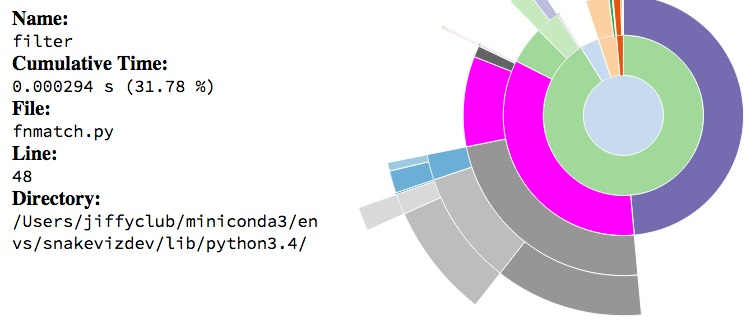

In [17]:
from ipython.display import Image

Image("images/func_info.jpg", width=400)

### vprof, py-spy

See [vprof](https://github.com/nvdv/vprof) or [py-spy](https://github.com/benfred/py-spy). The second one outputs a SVG file easy to handle.

In [18]:
# from vprof import profiler

# needs to be run from a file not from a notebook
# profiler.run(toprofile0, 'cmh', args=(sample1000,), host='localhost', port=8000)

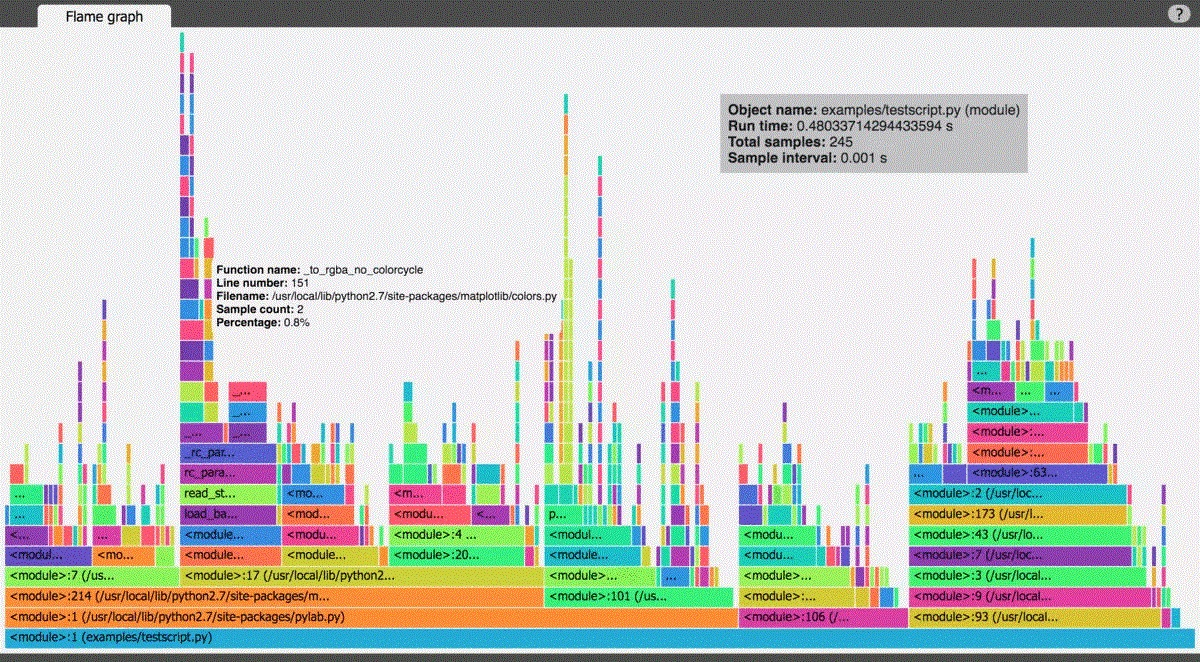

In [19]:
from ipython.display import Image

Image("images/vprof.jpg", width=800)